In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from data import fut_list, fut_read, stock_read
from util import adf_test, data_generator, significant, johansen_cointegration_test, EG, benefits_show

# Config

In [24]:

fut = fut_list[2]
feature = 'close'
fut
# fut_list

'HC9999.XSGE'

# DATA
* 数据基础已经全部存在data里了。只需进一步处理得到想要的时间序列。

In [25]:
fut_df = fut_read(fut)
stock_df = stock_read(fut)

/Users/hejizhang/Downloads/主连日线-2018年后/data.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fut['ChangeRatio'].iloc[0] = 0


### 如果想要定制特征，处理fut_df \ stock_df即可。

# ADF验证是否平稳

In [35]:
adf_list = []
for idx, df in enumerate(stock_df):
   adf_list.append(adf_test(df[feature]))
adf_list.append(adf_test(fut_df[feature]))
adf_df = pd.concat(adf_list, axis=1)   
adf_df = adf_df.T
del adf_df['Number of Observations Used']

对于changeratio而言，是平稳的

# 根据模型找出各个stock的联动显著时间段
* 由于只有VAR，故不再对模型选择进行分支。
* 由于p=0.05基本找不到显著的时间段，改成了0.10
* y是股票的y。第一个p是const的，第二个是期货前一时刻特征的p，第三个是股票前一时刻的特征的p。

## 先算一下相关性
* 这个只算了一个期货和具体股票某个特征的收益。
* 看下面收益率的corr，相关性还挺高。
* 与此同时，把数据的describe也写上了。

In [68]:
import pandas as pd

data = {
    'count': [1194, 1194, 1193, 1172, 1194],
    'mean': [0.000418, 0.000270, 0.000413, 0.000161, -0.000094],
    'std': [0.020427, 0.024415, 0.023424, 0.024485, 0.021139],
    'min': [-0.099448, -0.098592, -0.099323, -0.099762, -0.099010],
    '25%': [-0.009845, -0.010724, -0.011792, -0.010401, -0.010230],
    '50%': [-0.001413, 0.000000, 0.000000, -0.001834, 0.000000],
    '75%': [0.009122, 0.008621, 0.011215, 0.009283, 0.009585],
    'max': [0.098901, 0.102326, 0.100539, 0.100977, 0.100649]
}

df2 = pd.DataFrame(data)
df2

,count,mean,std,min,25%,50%,75%,max
0,1194,0.000418,0.020427,-0.099448,-0.009845,-0.001413,0.009122,0.098901
1,1194,0.000270,0.024415,-0.098592,-0.010724,0.000000,0.008621,0.102326
2,1193,0.000413,0.023424,-0.099323,-0.011792,0.000000,0.011215,0.100539
3,1172,0.000161,0.024485,-0.099762,-0.010401,-0.001834,0.009283,0.100977
4,1194,-0.000094,0.021139,-0.099010,-0.010230,0.000000,0.009585,0.100649


In [66]:
corr_list = []
data_describe = []
for df in stock_df:
    data = data_generator(fut_df, df, feature)
    corr_list.append(data[0].corr())
    data_describe.append(data[0].describe())
# corr_list
data_describe

[       ChangeRatio_df1  ChangeRatio_df2
 count      1194.000000      1194.000000
 mean          0.000092         0.000418
 std           0.014810         0.020427
 min          -0.078103        -0.099448
 25%          -0.007697        -0.009845
 50%           0.000768        -0.001413
 75%           0.008488         0.009122
 max           0.058445         0.098901,
        ChangeRatio_df1  ChangeRatio_df2
 count      1194.000000      1194.000000
 mean          0.000092         0.000270
 std           0.014810         0.024415
 min          -0.078103        -0.098592
 25%          -0.007697        -0.010724
 50%           0.000768         0.000000
 75%           0.008488         0.008621
 max           0.058445         0.102326,
        ChangeRatio_df1  ChangeRatio_df2
 count      1193.000000      1193.000000
 mean          0.000084         0.000413
 std           0.014813         0.023424
 min          -0.078103        -0.099323
 25%          -0.007711        -0.011792
 50%          

#### 主意这个找显著，都是90%置信读就行。因为95%的找不到。

In [4]:
sig_col = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    sig_col.append(significant(data))
sig_col
# 要画什么图根据这个再改一改。

[([[0, array([0.07669832, 0.03720587, 0.01438783])],
   [1, array([0.07110896, 0.03989815, 0.02220851])],
   [3, array([0.03700736, 0.02427026, 0.03001648])],
   [461, array([0.06187387, 0.01776586, 0.09157615])],
   [462, array([0.07216438, 0.01201078, 0.06453823])],
   [543, array([0.09130337, 0.00218921, 0.0152069 ])],
   [846, array([0.04396597, 0.08938499, 0.0434864 ])],
   [847, array([0.02516317, 0.07404043, 0.03527982])]],
  []),
 ([[3, array([0.09983438, 0.02048287, 0.02625046])],
   [5, array([0.06254327, 0.0106275 , 0.03478245])],
   [6, array([0.0279161 , 0.01415837, 0.0375582 ])],
   [137, array([0.04668035, 0.09926507, 0.06327435])],
   [138, array([0.07776827, 0.03992777, 0.04845521])],
   [139, array([0.06423892, 0.03505261, 0.05556232])],
   [141, array([0.09273869, 0.0355535 , 0.07064869])],
   [142, array([0.09610814, 0.03836194, 0.07086439])],
   [256, array([0.02002243, 0.0120848 , 0.01287456])],
   [357, array([0.00793185, 0.09517341, 0.05815873])],
   [724, array

上面sig为list。list 0-4表明对应的stock。

比如list[0]中，就存了期股联动显著的时间切片。list中第一个数字是时间切片编号，第二个是三个p。p的解释如上

sig_col 即为显著的index

还有更进一步的算最佳lead lag,不过都是1，所以似乎不重要了,写在下面。可以尝试下冲击

```python
lag_order = model.select_order(15)
print(f"Selected lag order: {lag_order.selected_orders['aic']}")
model_fitted = model.fit(maxlags=lag_order.selected_orders['aic'])
print(model_fitted.summary())

irf = model_fitted.irf(10) # 10期冲击响应
irf.plot(orth=True) # 正交化冲击响应图
plt.show()

```

# 画图

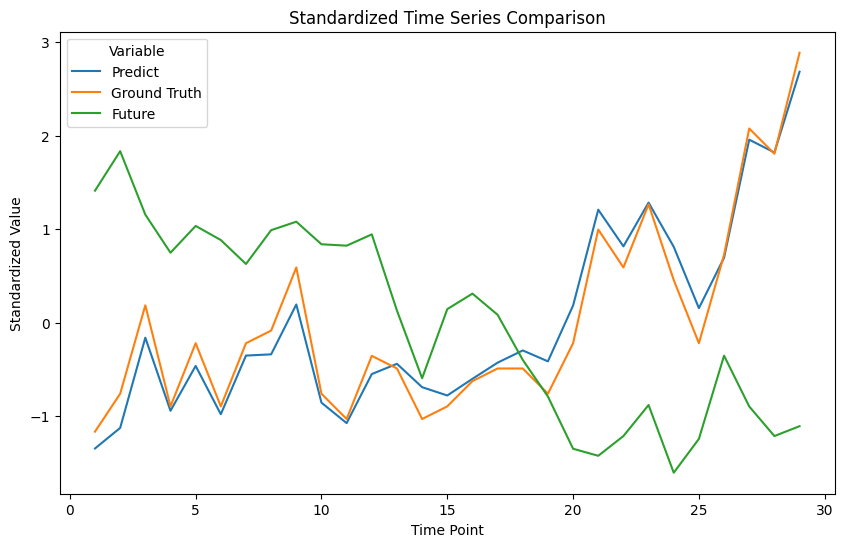

In [6]:
data, label = data_generator(fut_df, stock_df[0], feature)
benefits_show(0, data)

# 协整检验
* 只用检验上面的data数据（就是一列是期货数据，一列是股票数据）

!! 只看一次，所以只用了一个break

In [71]:
# print('Results of Johansen Cointegration Test:')
# print(f"Test statistic: {result.lr1}")
# print(f"Critical values: {result.cvt}")
# print(f"Eigenstatistics: {result.lr2}")
# print(f"Eigenvalues: {result.eig}")
Test_statistic = []
Critical_values = []
Eigenstatistic = []
Eigenvalues = []
for idx, df in enumerate(stock_df):
    data = data_generator(fut_df, df, feature)
    test_result = johansen_cointegration_test(data[0])
    Test_statistic.append(test_result.lr1)
    Critical_values.append(test_result.cvt)
    Eigenstatistic.append(test_result.lr2)
    Eigenvalues.append(test_result.eig)

# 可以很方便的改成df

In [77]:
Critical_values
# pd.DataFrame(Critical_values)

[array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]])]

# E-G协整检验

* 对回归残差的检验

* result是股票对期货回归得到的模型的参数。比如t值 p值 r^2等

In [26]:
result_list = []
output_list = []
for df in stock_df:
    data, label = data_generator(fut_df, df, feature)
    result_df, output = EG(data)
    result_list.append(result_df)
    output_list.append(output)


In [27]:
output_list

[Test Statistic                   -4.821090
 p-value                           0.000050
 #Lags Used                        7.000000
 Number of Observations Used    1186.000000
 Critical Value (1%)              -3.435876
 Critical Value (5%)              -2.863980
 Critical Value (10%)             -2.568069
 dtype: float64,
 Test Statistic                   -2.386188
 p-value                           0.145673
 #Lags Used                       18.000000
 Number of Observations Used    1175.000000
 Critical Value (1%)              -3.435928
 Critical Value (5%)              -2.864003
 Critical Value (10%)             -2.568081
 dtype: float64,
 Test Statistic                   -4.494933
 p-value                           0.000201
 #Lags Used                        3.000000
 Number of Observations Used    1189.000000
 Critical Value (1%)              -3.435862
 Critical Value (5%)              -2.863974
 Critical Value (10%)             -2.568066
 dtype: float64,
 Test Statistic          

# VECM

### 下面这个是VAR的

下面表明最好的lag一般是1

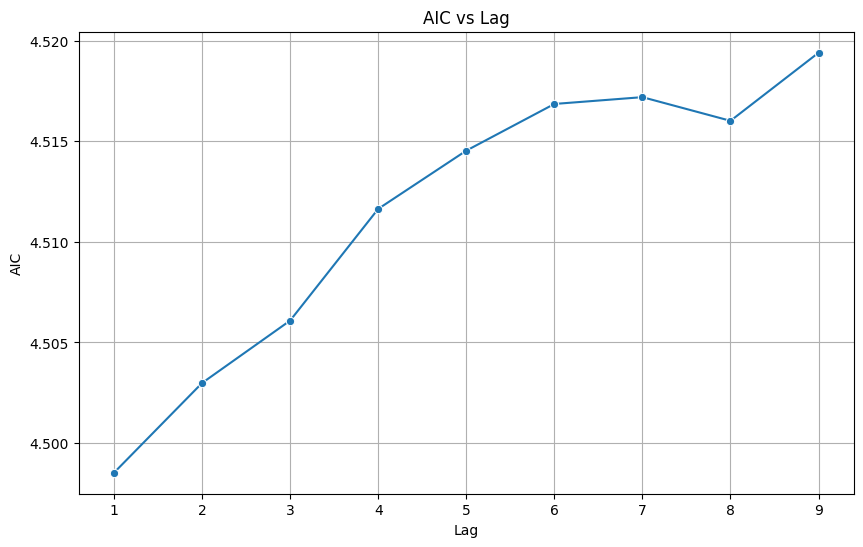

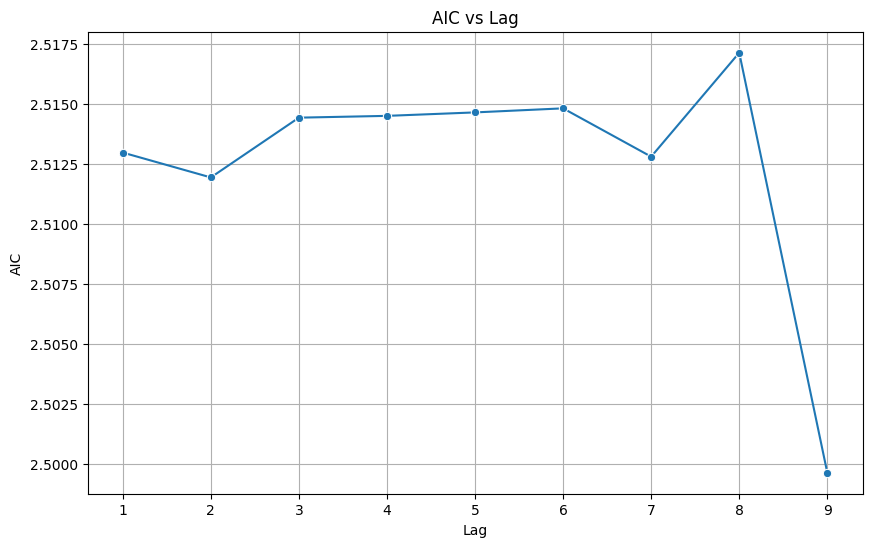

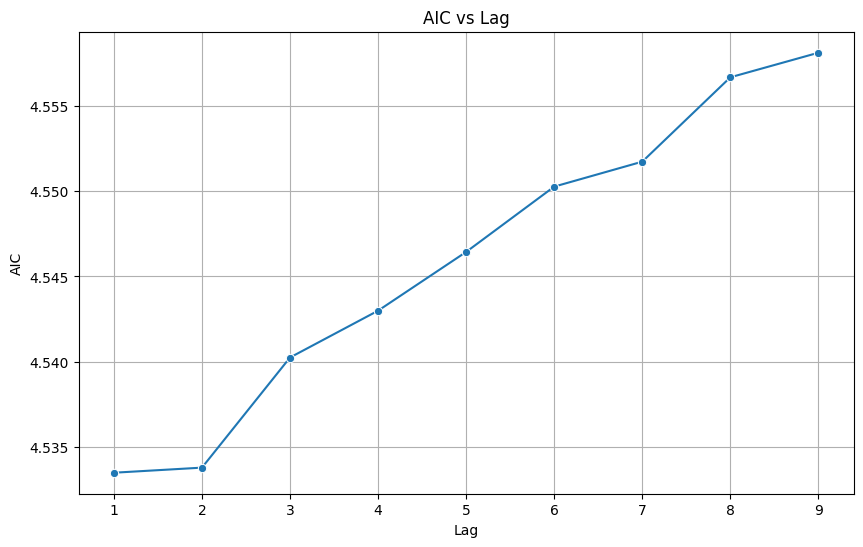

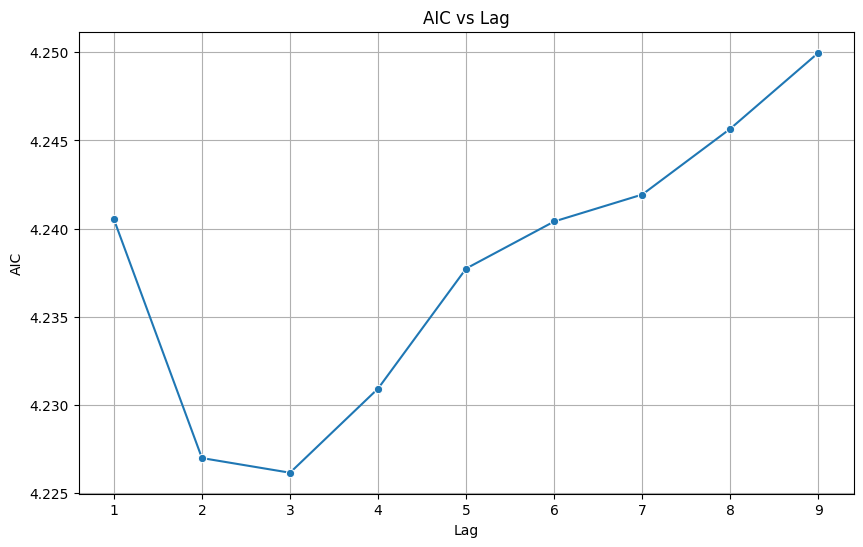

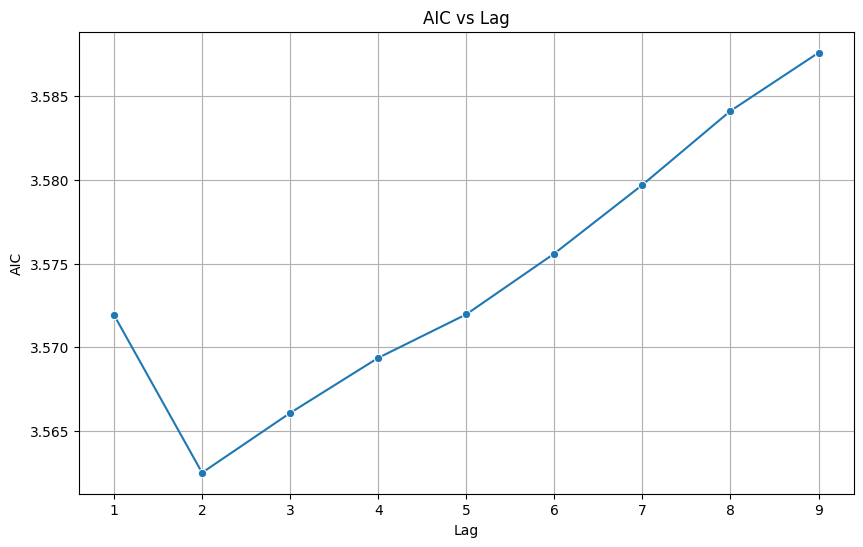

In [34]:

for df in stock_df:
    aic_values = []
    data, label = data_generator(fut_df, df, feature)

    for lag in range(1, 10):
        model = VAR(data)
        results = model.fit(lag)
        aic = results.aic
        aic_values.append(aic)
    df = pd.DataFrame({'Lag': np.linspace(1,9,9), 'AIC': aic_values})

    import seaborn as sns
    # 使用 Seaborn 绘制折线图
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Lag', y='AIC', marker='o')
    plt.title('AIC vs Lag')
    plt.xlabel('Lag')
    plt.ylabel('AIC')
    plt.grid(True)
    plt.show()

### 下面这个是VECM

In [25]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
vecm_list = []
for df in stock_df:
    data = data_generator(fut_df, df, feature)
    lag_order = select_order(data=data, maxlags=10, deterministic="ci").selected_orders['aic']
    print(f"Selected lag order by AIC: {lag_order}")
    vecm = VECM(endog=data, k_ar_diff=lag_order, coint_rank=1, deterministic="ci")
    vecm_fitted = vecm.fit()
    vecm_list.append(vecm_fitted)


Selected lag order by AIC: 1
Selected lag order by AIC: 1
Selected lag order by AIC: 1
Selected lag order by AIC: 1
Selected lag order by AIC: 2


可能还需要看的就是VECM表中对应的信息是啥意思了。

In [ ]:
vecm_list

！！！牛魔这个每个lag对应的AIC实在找不到方法求。VECM没有提供AIC的功能，select_order只返回一个最好的lag的AIC。想画图画布不了。放弃了。

# 试着算VCM的胜率

* sig_list跟之前的sig_col是一个意思。表示显著的时间。
* acc_list则是每个时间切片的胜率。我们可以根据sig_list中显著时间对应的index直接在acc_list中找。

In [7]:
sig_list = []
acc_list = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    sig, acc = significant(data, label)
    sig_list.append(sig)
    acc_list.append(acc)


下面举个例子。可以看到胜率是0.73333

In [19]:
# 举个例子 改sig_list第二个索引
idx = sig_list[0][5][0]
win = acc_list[0][idx]
win

0.7333333333333333

# ATE（暂时失败）

In [4]:
import numpy as np
from causalinference import CausalModel

# 生成示例数据
np.random.seed(0)
n = 1000
A = np.random.normal(loc=0, scale=1, size=n)
B = 2 * A + np.random.normal(loc=0, scale=1, size=n)

# 由于示例中没有协变量X，我们可以创建一个全为1的数组作为占位符
# 这样做是为了满足CausalModel的参数要求
X = np.ones((n, 1))

# 创建因果推断模型
# 注意：这里我们直接传递Y（结果变量B）、D（处理变量A）和X（协变量）
causal_model = CausalModel(Y=B, D=A, X=X)

# 进行因果推断分析
causal_model.est_via_ols(adj=1)
print(causal_model.estimates)

# 获取平均因果效应（ATE）
ate = causal_model.estimates['ols']['ate']
print("Average Treatment Effect (ATE):", ate)


ValueError: Too few treated units: N_t < K+1